# Simulating FEE on MC data

Develops the procedure to simulate the effect of FEE in NEXT MC data

In [336]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
#%matplotlib nbagg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [338]:
import FEE as FE

In [339]:
import time

## Revised on:

In [340]:
print(time.strftime("%d/%m/%Y"))

04/11/2016


In [341]:
print(time.strftime("%H:%M:%S"))

23:35:30


###  Code exercized

In [342]:
!pep8 ../Sierpe/FEE.py

../Sierpe/FEE.py:1:1: E902 IOError: [Errno 2] No such file or directory: '../Sierpe/FEE.py'


In [343]:
!pyflakes ../Sierpe/FEE.py

../Sierpe/FEE.py: No such file or directory


## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e

In [344]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

#### List the files

In [345]:
#ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

#### Open and inspect files

In [346]:
kr2609 = tables.open_file('F:/DATOS_DAC/run_2609_kr.root.h5','r+')

In [347]:
kr2609

File(filename=F:/DATOS_DAC/run_2609_kr.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/pmtrwf (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/sipmrwf (EArray(1365, 1792, 1200), shuffle, zlib(4)) ''
  atom := I

In [348]:
e2500 = tables.open_file('F:/DATOS_DAC/electrons.2500.0keV.z250mm.next_1000.root.h5','r+')

In [349]:
e1250 = tables.open_file('F:/DATOS_DAC/electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [350]:
e40 = tables.open_file('F:/DATOS_DAC/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [351]:
pmtrd = e40.root.pmtrd

#### Plot pmtrd for the first event, first PMT

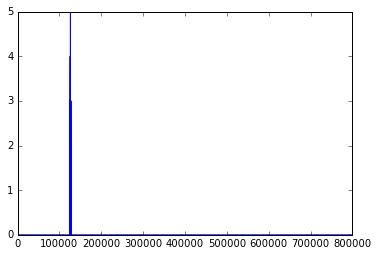

In [352]:
plt.plot(pmtrd[0,0])

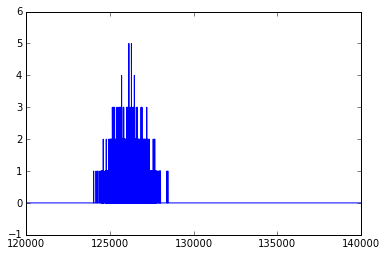

In [353]:
mpl.plts(pmtrd[0,0], signal_start=120000, signal_end=140000, offset=1)

In [354]:
print('area of kripton events in pe ={}'.format(np.sum(pmtrd[0,0])))

area of kripton events in pe =1210


#### signal_i : convolute pmtrd with spe

In [355]:
spe = FE.SPE()

In [356]:
spe


        (PMT gain = 4.5e+06, amplitude = 1.2e+02 muA
         slope =  5.00 ns, flat =  1.00 ns)
        

In [357]:
signal_i = FE.spe_pulse_from_vector(spe,pmtrd[0,0])  # in current units

#### Create FEE instance

In [358]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [359]:
fee


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31
        )
        

#### plot input function

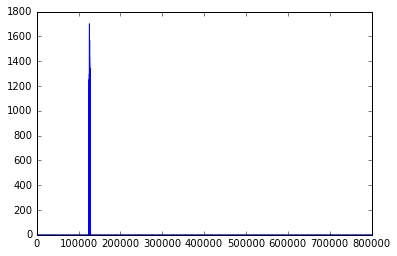

In [360]:
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(fee))   #plot input signal in adc counts

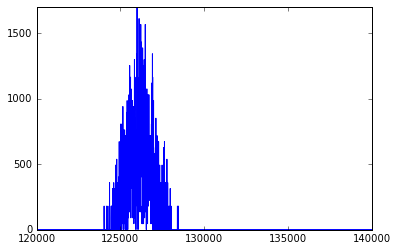

In [361]:
mpl.plts(signal_i*FE.i_to_adc(fee), signal_start=120000, signal_end=140000, offset=2)

### Decimate

#### sampling frequencies

In [362]:
f_sample1 = (1./(1*units.ns))

In [363]:
f_sample2 = (1./(25*units.ns))

In [364]:
f_sample1/units.MHZ

1000.0

In [365]:
f_sample2/units.MHZ

40.0

In [366]:
scale = int(f_sample1/f_sample2)

In [367]:
scale

25

### Decimation

In [368]:
signal_d = FE.daq_decimator(f_sample1, f_sample2, signal_i)

In [369]:
len(signal_i)

800000

In [370]:
len(signal_d)

32000

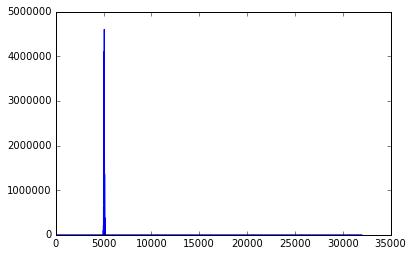

In [371]:
plt.plot(signal_d)

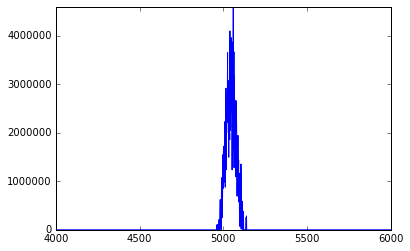

In [372]:
mpl.plts(signal_d, signal_start=4000, signal_end=6000, offset=2)

### Convolve with FEE

In [373]:
signal_fee = FE.noise_adc(fee, FE.signal_v_fee(fee, signal_d))*FE.v_to_adc(fee)  #in adc counts

In [374]:
print "TRUE TOTAL Out Noise (Check Point 1(LSB_rms)) =",np.std(signal_fee[9500:10000],ddof=1)

TRUE TOTAL Out Noise (Check Point 1(LSB_rms)) = 0.894139233282


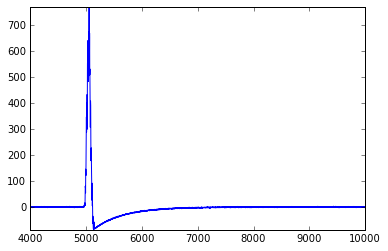

In [375]:
mpl.plts(signal_fee, signal_start=4000, signal_end=10000, offset=2)

### Remove the effect of filter

#### cleaning filter

In [376]:
signal_c = FE.signal_clean(fee, signal_fee)

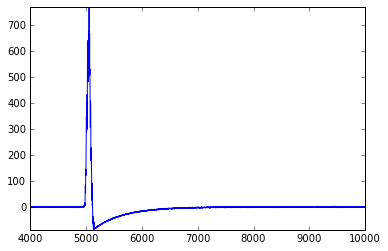

In [377]:
mpl.plts(signal_c, signal_start=4000, signal_end=10000, offset=2)

In [378]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [379]:
signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)

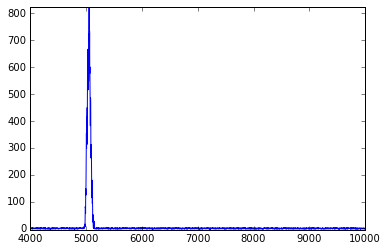

In [380]:
mpl.plts(signal_r, signal_start=4000, signal_end=10000, offset=2)

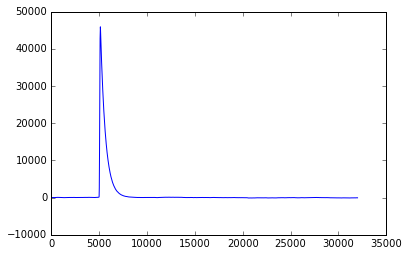

In [381]:
plt.plot(acum)

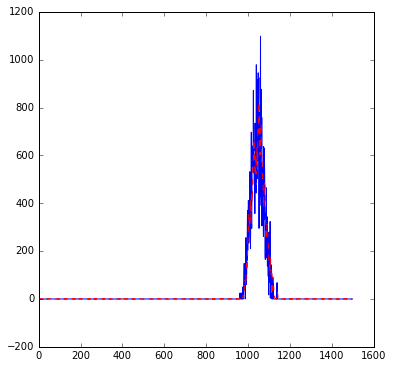

In [382]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4000:5500]*FE.i_to_adc(fee))
plt.plot(signal_r[4000:5500],'r--', linewidth=1)
plt.show()

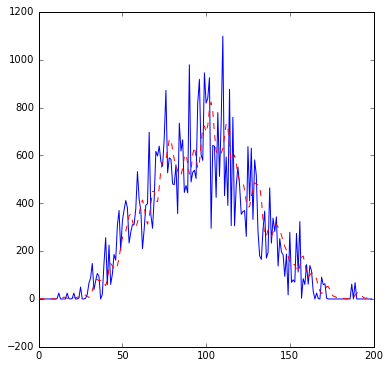

In [383]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:5150]*FE.i_to_adc(fee))
plt.plot(signal_r[4950:5150],'r--', linewidth=1)
plt.show()

In [384]:
energy_mea=np.sum(signal_r[4950:5150])
energy_in=np.sum(signal_d[4950:5150]*FE.i_to_adc(fee))
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 52608.1507606
Reconstructed Energy = 52711.8639958
Error in Energy Computation (%) = -0.197142902267


In [385]:
def fee_response(h5f, event=0, pmt=0):
    """
    returns:
    input function (after daq decimation)
    convoluted function (after FEE)
    recovered function (after cleaning filter and BLR)
    all in adc counts
    """
    pmtrd = h5f.root.pmtrd
    spe = FE.SPE()
    signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
    signal_fee = FE.noise_adc(fee,FE.signal_v_fee(fee, signal_d))*FE.v_to_adc(fee)  #in adc counts
    print "TRUE TOTAL Out Noise (Check Point 1(LSB_rms)) =",np.std(signal_fee[25000:26000],ddof=1)
    signal_c = FE.signal_clean(fee, signal_fee)
    signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)
    
    return signal_d*FE.i_to_adc(fee), signal_fee, signal_r

In [386]:
signal_d, signal_fee, signal_r = fee_response(e1250, event=10, pmt=0)

TRUE TOTAL Out Noise (Check Point 1(LSB_rms)) = 0.854065546223


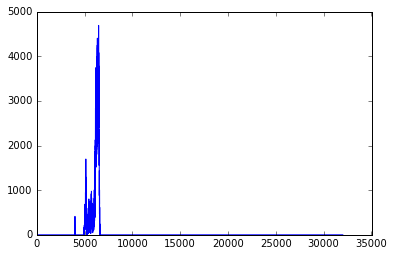

In [387]:
plt.plot(signal_d)

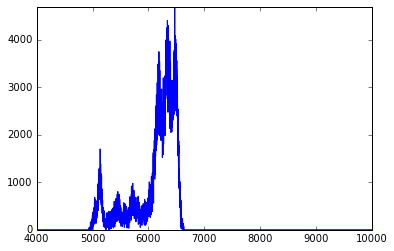

In [388]:
mpl.plts(signal_d, signal_start=4000, signal_end=10000, offset=2)

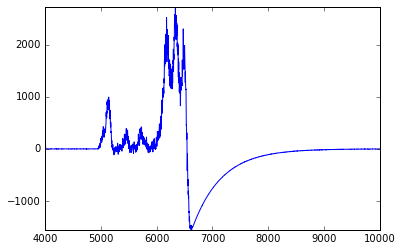

In [389]:
mpl.plts(signal_fee, signal_start=4000, signal_end=10000, offset=2)

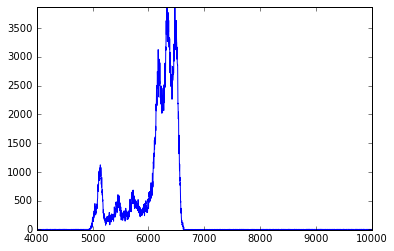

In [390]:
mpl.plts(signal_r, signal_start=4000, signal_end=10000, offset=2)

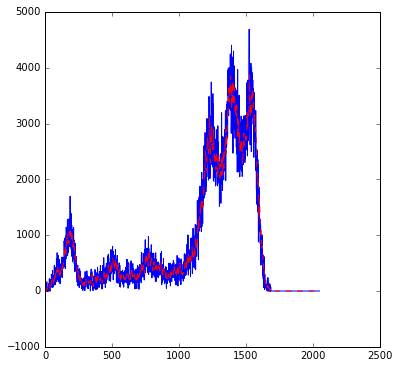

In [391]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:7000])
plt.plot(signal_r[4950:7000],'r--', linewidth=1)
plt.show()

In [392]:
energy_mea=np.sum(signal_r[4950:7000])
energy_in=np.sum(signal_d[4950:7000])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 1675713.79741
Reconstructed Energy = 1676033.62352
Error in Energy Computation (%) = -0.0190859621783


In [393]:
signal_d, signal_fee, signal_r = fee_response(e2500, event=100, pmt=0)

TRUE TOTAL Out Noise (Check Point 1(LSB_rms)) = 0.88073673043


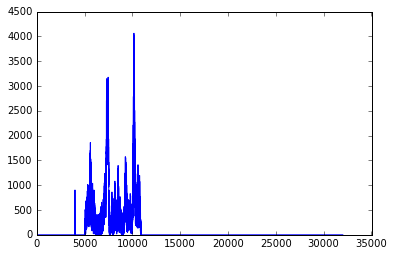

In [394]:
plt.plot(signal_d)

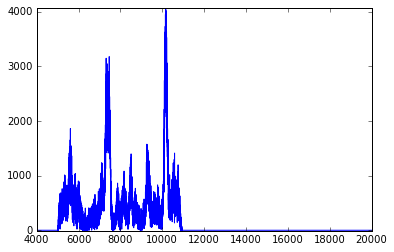

In [395]:
mpl.plts(signal_d, signal_start=4000, signal_end=20000, offset=10)

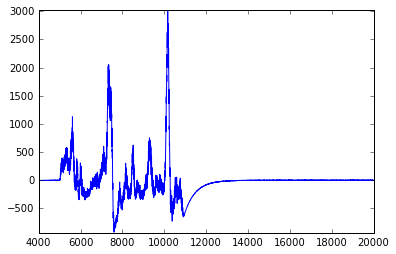

In [396]:
mpl.plts(signal_fee, signal_start=4000, signal_end=20000, offset=10)

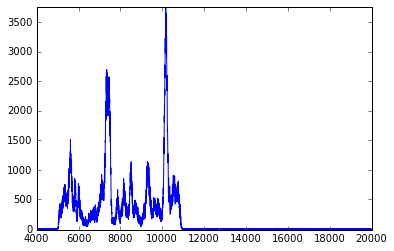

In [397]:
mpl.plts(signal_r, signal_start=4000, signal_end=20000, offset=10)

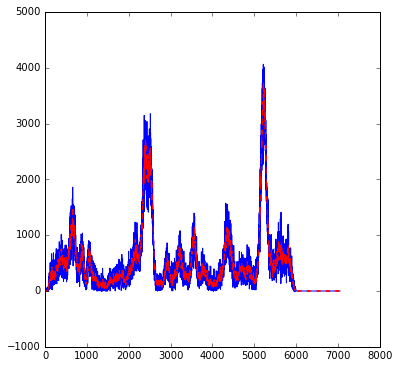

In [398]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:12000])
plt.plot(signal_r[4950:12000],'r--', linewidth=1)
plt.show()

In [399]:
energy_mea=np.sum(signal_r[4950:12000])
energy_in=np.sum(signal_d[4950:12000])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 3268050.48835
Reconstructed Energy = 3267172.60237
Error in Energy Computation (%) = 0.0268626810939


In [400]:
pmtrwf = kr2609.root.RD.pmtrwf

In [401]:
def find_baseline(x):
    # Finds baseline in a given sequence 
    length_signal = np.size(x)
    baseline = x.sum() / length_signal      
    return baseline 

In [419]:
def BLR_vhb(signal_daq, coef, thr = 0, C1=3100E-9, filter=False):

    """
    Only for calibration

    """
   
    baseline = 4096-find_baseline(signal_daq[0:1000])
    signal_daq = (4096 - signal_daq) - baseline
    
    print ("NOISE (LSB_rms)= ",np.std(signal_daq[0:1000],ddof=1))

    if (filter==True):
        #C1=3100E-9; #C1=2714E-9;
        R1=1567;
        f_sample = (1/25E-9)
        freq_zero = 1/(R1*C1);
        freq_zerod = freq_zero / (f_sample*np.pi)
        b_cf, a_cf = signal.butter(2, freq_zerod, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
    

    
    len_signal_daq = len(signal_daq)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    
    
    nm = 128
    B_MAU = (1./nm)*np.ones(nm)
    MAU[nm-1] = np.mean(signal_daq[0:nm])

    #SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    #acum[nm] =  MAU[nm-1]
    BASELINE = MAU[nm-1]

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    signal_r[0:nm] = signal_daq[0:nm] 

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window
    cond = 0
    

    for k in range(nm,len_signal_daq): 

            
        trigger_line = MAU[k] + thr

        # condition: raw signal raises above trigger line and 
        if (signal_daq[k] > trigger_line) or cond == 1:

            cond = 1
            
            #update recovered signal, correcting by offset           
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - BASELINE;            

            
        else:
            MAU[k] = np.mean(signal_daq[k-nm+1:k+1])
            BASELINE = MAU[k]
            signal_r[k] = signal_daq[k]-BASELINE
            x_trigger = k



    return  signal_r

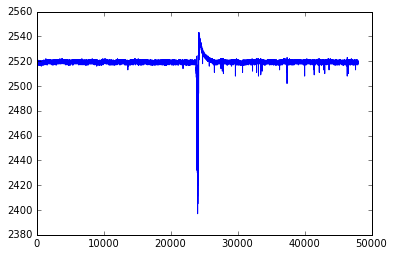

In [420]:
plt.plot(pmtrwf[0,0])

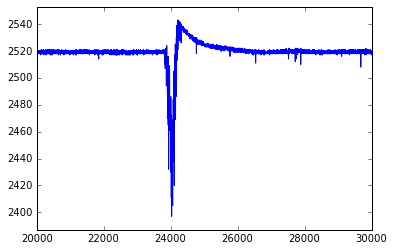

In [421]:
mpl.plts(pmtrwf[0,0], signal_start=20000, signal_end=30000, offset=10)

In [422]:
b,a = FE.filter_cleaner(fee)

In [423]:
out_clean =BLR_vhb(pmtrwf[0,0],1.6324E-3,thr=6,C1=2905E-9,filter=True)

('NOISE (LSB_rms)= ', 0.79094917700229039)


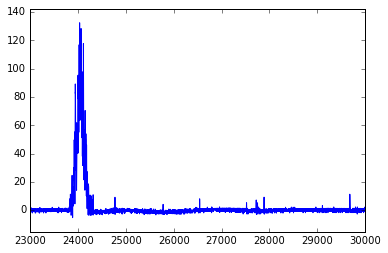

In [426]:
mpl.plts(out_clean, signal_start=23000, signal_end=30000, offset=10)

In [432]:
print find_baseline(out_clean[23000:23500])

-0.0198496513745


In [433]:
print find_baseline(out_clean[25000:25500])

-0.602987406822


In [434]:
print find_baseline(out_clean[27000:27500]) 

0.0356113433523
